In [1]:
nltk.download('stopwords')

NameError: ignored

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/kaggle_code/data/week_30/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/kaggle_code/data/week_30/test.csv")

In [5]:
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


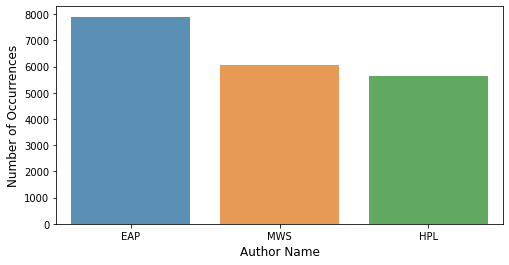

In [6]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [7]:
# 5줄 프린트
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
  print('Author name :', name)
  cnt = 0
  for ind, row in group.iterrows():
    print(row['text'])
    cnt += 1
    if cnt == 5:
      break
  print('\n')

Author name : EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you could

# Feature Engineering
1. Meta features : 단어의 수, 스탑워드의 수, 특수부호의 수로 특징추출
2. Text based features : svd, 빈도, word2vec을 기반으로한 추출

## meta features
- 단어의 수
- unique한 단어의 수
- 문자의 수
- 스탑워드의 수
- 특수문자의 수
- 대문자 수
- title case word의 수
- 평균 단어 길이

In [8]:
# 단어의 수
train_df['num_words'] = train_df['text'].apply(lambda x : len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x : len(str(x).split()))

# unique한 단어의 수
train_df['num_unique_words'] = train_df['text'].apply(lambda x : len(set(str(x).split())))
test_df['num_unique_words'] = test_df['text'].apply(lambda x : len(set(str(x).split())))

# character 수
train_df['num_chars'] = train_df['text'].apply(lambda x : len(str(x)))
test_df['num_chars'] = test_df['text'].apply(lambda x : len(str(x)))

# stopwords 수
train_df['num_stopwords'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df['num_stopwords'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# 문장부호의 수
train_df['num_punctuations'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['num_punctuations'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# title case 수
train_df['num_words_upper'] = train_df['text'].apply(lambda x : len([w for w in str(x).split() if w.isupper()]))
test_df['num_words_upper'] = test_df['text'].apply(lambda x : len([w for w in str(x).split() if w.isupper()]))

# 평균길이
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len'] = test_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))


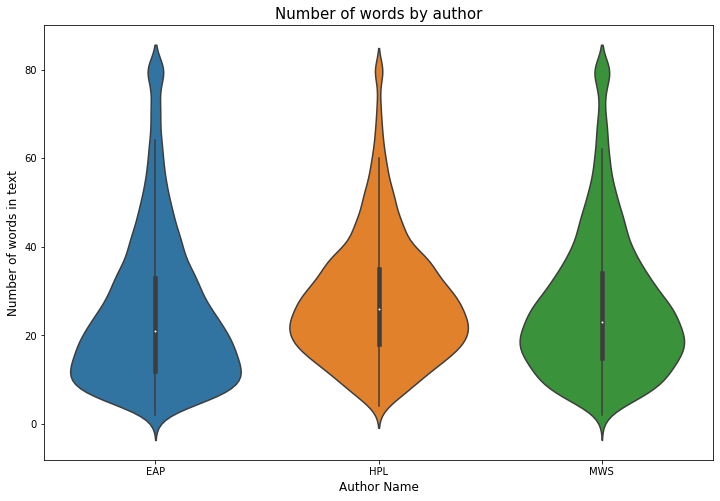

In [9]:
train_df['num_words'].loc[train_df['num_words']>80] = 80
plt.figure(figsize=(12, 8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

EAP가 다른것들에 비해 단어 수가 적음

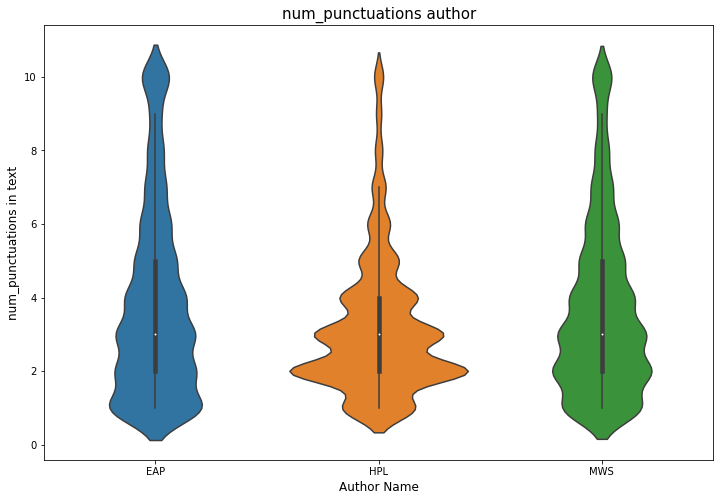

In [10]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 # 10 넘는거는 10으로
plt.figure(figsize=(12, 8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('num_punctuations in text', fontsize=12)
plt.title("num_punctuations author", fontsize=15)
plt.show()

In [11]:
author_mapping_dict = {'EAP':0, 'HPL':1, "MWS":2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

train_df['num_words']=train_df['text'].apply(lambda x : len(str(x).split()))
test_df['num_words']=test_df['text'].apply(lambda x : len(str(x).split()))
train_df['mean_word_len']=train_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len']=test_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [12]:
!pip install xgboost

In [13]:
import xgboost as xgb
print(xgb.DMatrix)

<class 'xgboost.core.DMatrix'>


In [14]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
  param = {}
  param['objective']='multi:softprob'
  param['eta']=0.1
  param['max_depth']=3
  param['silent']=1
  param['num_class']=3
  param['eval_metric']='mlogloss'
  param['subsample']=0.8
  param['colsample_bytree'] = colsample
  param['seed'] = seed_val
  num_rounds = 2000

  plst = list(param.items())
  xgtrain = xgb.DMatrix(train_X, label = train_y)
  
  if test_y is not None:
    xgtest = xgb.DMatrix(test_X, label=test_y)
    watchlist=[(xgtrain, 'train'), (xgtest, 'test')]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50,
                      verbose_eval=20)
  else:
    xgtest = xgb.DMatrix(test_X)
    model = xgb.train(plst, xgtrain, num_rounds)

  pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)

  if test_X2 is not None:
    xgtest2 = xgb.DMatrix(test_X2)
    pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)

  return pred_test_y, pred_test_y2, model

In [15]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])

for dev_index, val_index in kf.split(train_X):
  dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
  dev_y, val_y = train_y[dev_index], train_y[val_index]
  pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
  pred_full_test = pred_full_test + pred_test_y
  pred_train[val_index, :] = pred_val_y
  cv_scores.append(metrics.log_loss(val_y, pred_val_y))
  break
print('cv scores : ', cv_scores)

[0]	train-mlogloss:1.09356	test-mlogloss:1.09448
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.03981	test-mlogloss:1.05069
[40]	train-mlogloss:1.02304	test-mlogloss:1.0394
[60]	train-mlogloss:1.01197	test-mlogloss:1.03199
[80]	train-mlogloss:1.00303	test-mlogloss:1.02654
[100]	train-mlogloss:0.99584	test-mlogloss:1.02209
[120]	train-mlogloss:0.988838	test-mlogloss:1.01712
[140]	train-mlogloss:0.982641	test-mlogloss:1.01406
[160]	train-mlogloss:0.977904	test-mlogloss:1.01173
[180]	train-mlogloss:0.972682	test-mlogloss:1.00946
[200]	train-mlogloss:0.969084	test-mlogloss:1.00849
[220]	train-mlogloss:0.965384	test-mlogloss:1.0072
[240]	train-mlogloss:0.961478	test-mlogloss:1.00539
[260]	train-mlogloss:0.958299	test-mlogloss:1.00442
[280]	train-mlogloss:0.955439	test-mlogloss:1.00362
[300]	train-mlogloss:0.952471	test-mlogloss:1.00341
[320]	train-mlogloss:0.949371	t

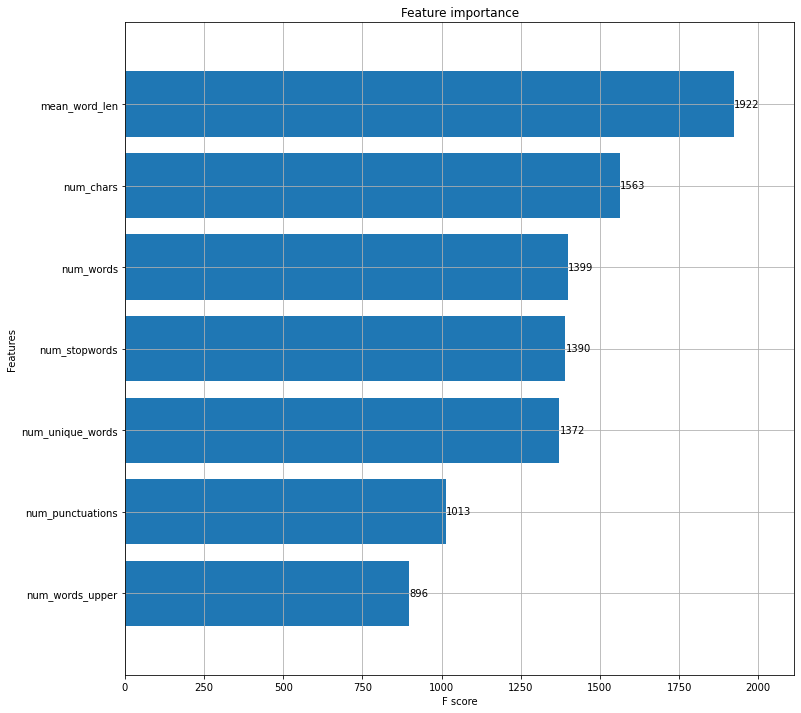

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

num of char, mean word len, num words가 3개 높은 변수이다.

## test based features

In [17]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist()+
                                     test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform((test_df['text'].values.tolist()))

tfidf는 sparse한 데이터이다. 이를 dense feature로 만들기 위해서는 n개의feature를 선택후 convert하거나 concat한다. <br>

sparse한 feature로 모델을 만들고 그리고 다른 dense한 featuer와 함께 하나의 features로 predict하면됨

In [18]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
  model = naive_bayes.MultinomialNB()
  model.fit(train_X, train_y)
  pred_test_y = model.predict_proba(test_X)
  pred_test_y2 = model.predict_proba(test_X2)
  return pred_test_y, pred_test_y2, model

In [19]:
cv_scores=[]
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
  dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
  dev_y, val_y = train_y[dev_index], train_y[val_index]
  pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
  pred_full_test = pred_full_test + pred_test_y
  pred_train[val_index, :] = pred_val_y
  cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.8422161983612855


In [20]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

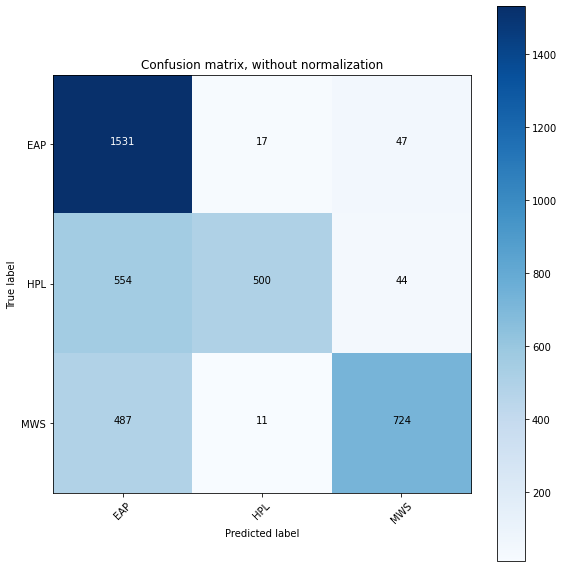

In [21]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

EAP에 많이 몰려있다

## TFIDF에 SVD 적용

In [22]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [23]:
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [24]:
cv_scores=[]
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
  dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
  dev_y, val_y = train_y[dev_index], train_y[val_index]
  pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
  pred_full_test = pred_full_test + pred_test_y
  cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.45091841616567435


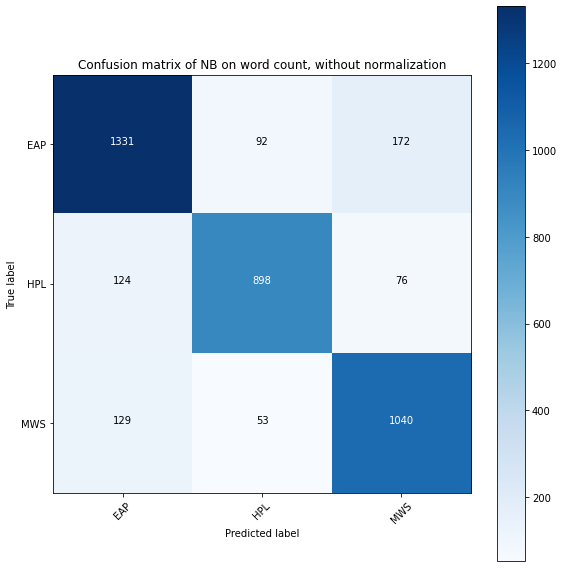

In [25]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

이전것 보다 confusion matrix가 더 밸런스 있어짐

In [26]:
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.7507639226818825


In [27]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947421


In [28]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [29]:
# 만든 변수들로 XGB돌림
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.00754	test-mlogloss:1.00778
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.441256	test-mlogloss:0.442865
[40]	train-mlogloss:0.376006	test-mlogloss:0.382423
[60]	train-mlogloss:0.352513	test-mlogloss:0.365038
[80]	train-mlogloss:0.33692	test-mlogloss:0.35449
[100]	train-mlogloss:0.324007	test-mlogloss:0.347256
[120]	train-mlogloss:0.31199	test-mlogloss:0.34232
[140]	train-mlogloss:0.301396	test-mlogloss:0.33819
[160]	train-mlogloss:0.292529	test-mlogloss:0.335665
[180]	train-mlogloss:0.283986	test-mlogloss:0.33405
[200]	train-mlogloss:0.276389	test-mlogloss:0.331807
[220]	train-mlogloss:0.268641	test-mlogloss:0.330416
[240]	train-mlogloss:0.26184	test-mlogloss:0.3293
[260]	train-mlogloss:0.255663	test-mlogloss:0.32811
[280]	train-mlogloss:0.249203	test-mlogloss:0.327352
[300]	train-mlogloss:0.243358	test-mlogloss:0.32723
[320]	train-mlogloss

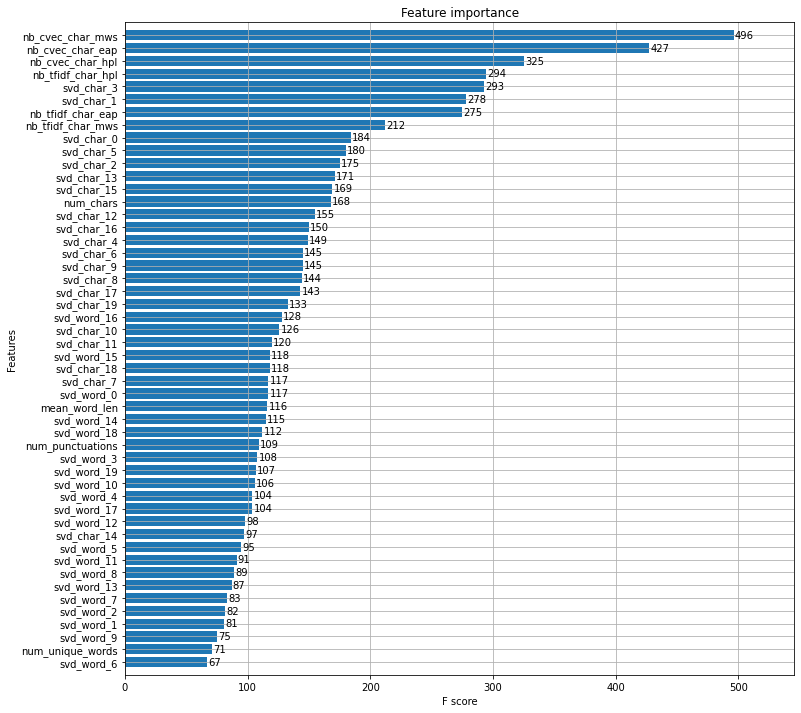

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

나이브 베이즈 특징들이 중요한 변수로 나옴

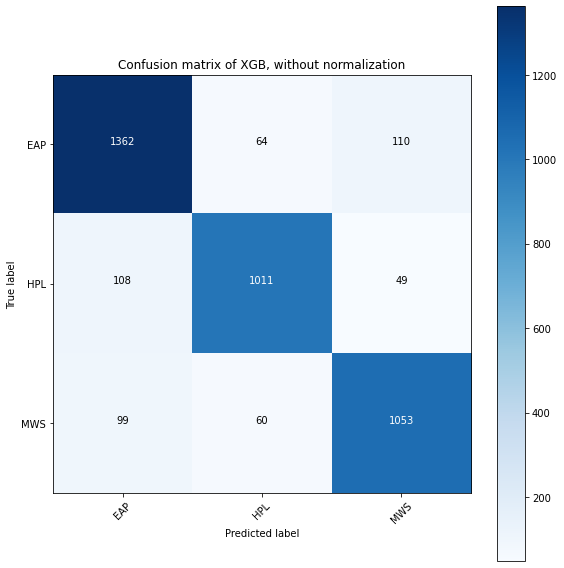

In [31]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

EAP와 MWS가 오분류된 경우가 많아 보인다.
이를 개선하기 위해 feature를 생성할 수 있다.
<br>

<개선방안>
1. embedding based feature
2. other meta features
3. 문장의 긍부정

<br>

<추가 개선방안>
1. 파라메타 튜빙(tfidf, count)
2. 나이브베이즈, XGB부스트 튜닝
3. 앙상블 스테이킹